In [1]:
import matplotlib
matplotlib.use('Agg')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Helpers
import sys
sys.path.insert(0,'../../')
from utils import data_path,results_path,grid_search,estimator_result,cross_validate,rfecv
from scipy.sparse import csr_matrix,save_npz,load_npz
from sklearn.model_selection import cross_val_score,LeaveOneOut,StratifiedKFold
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report
import pickle

# Algorithms
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Load data

In [4]:
with open('../' + data_path + 'sorted_TCRs_ind.pkl', 'rb') as f:
    TCRs_ind = pickle.load(f)
    
with open('../' + data_path + 'TCRs_stat.pkl', 'rb') as f:
    TCRs_stat_2 = pickle.load(f)

store = pd.HDFStore('../'+data_path+'TCRs.h5')
print(store.keys())

TCRs_stat = store['TCRs_stat']

['/TCRs_stat', '/TCRs_stat_T']


In [6]:
TCRs_stat.head()

,,,,,,,CMV+,CMV-,p_value
TCRBV09,TCRBV09-01,null,CASSGQGAYEQYF,TCRBJ02,TCRBJ02-07,01,61,12,7.958014e-13
TCRBV19,TCRBV19-01,null,CASSIGPLEHNEQFF,TCRBJ02,TCRBJ02-01,01,30,0,1.751455e-11
TCRBV05,TCRBV05-01,01,CASSPDRVGQETQYF,TCRBJ02,TCRBJ02-05,01,33,1,2.664239e-11
TCRBV07,TCRBV07-02,01,CASSLEAEYEQYF,TCRBJ02,TCRBJ02-07,01,30,1,3.202211e-10
TCRBV28,TCRBV28-01,01,CASSIEGNQPQHF,TCRBJ01,TCRBJ01-05,01,26,0,5.306200e-10


In [8]:
TCRs_stat_2

TCRBV01                                                             \
        TCRBV01-01                                                              
                01                                                              
         CTFQETQYF CTHGGHSLPTPSNQPQHF CTRGQGGTEAFF   CTSGEQYF CTSGGLAESTDTQYF   
           TCRBJ02            TCRBJ01      TCRBJ01    TCRBJ02         TCRBJ02   
        TCRBJ02-05         TCRBJ01-05   TCRBJ01-01 TCRBJ02-07      TCRBJ02-03   
                01                 01           01         01              01   
CMV+      2.000000                0.0          0.0    1.00000         1.00000   
CMV-      0.000000                2.0          2.0    1.00000         1.00000   
p_value   0.202886                1.0          1.0    0.69883         0.69883   

                                                                        \
                                                                         
                                                                         
        CTSGPSNQPQHF CTSGPYEQYF  CTSGYEQYF CTSILTRYNSNQPQHF CTSNPTEAFF   
             TCRBJ01    TCRBJ02    TCRBJ02          TCRBJ01    TCRBJ01   
          TCRBJ01-05 TCRBJ02-07 TCRBJ02-07       TCRBJ01-05 TCRBJ01-01   
                  01         01         01               01         01   
CMV+        2.000000    1.00000        0.0              0.0    1.00000   
CMV-        0.000000    1.00000        3.0              2.0    1.00000   
p_value     0.202886    0.69883        1.0              1.0    0.69883   

             ...                       null                       \
             ...                 unresolved                        
             ...                       null                        
             ...       CASSSSGLAGGRSSYNEQFF CASSSSPGLAGGSSYNEQFF   
             ...                    TCRBJ02              TCRBJ02   
             ...                 TCRBJ02-01           TCRBJ02-01   
             ...                         01                   01   
CMV+         ...                    1.00000              1.00000   
CMV-         ...                    1.00000              1.00000   
p_value      ...                    0.69883              0.69883   

                                                                    \
                                                                     
                                                                     
        CASSSTGAGNQPQHF CASSSYNLRGGGRGGRNEQFF CASSTGLAGGLSSGANVLTF   
                TCRBJ01               TCRBJ02              TCRBJ02   
             TCRBJ01-05            TCRBJ02-01           TCRBJ02-06   
                     01                    01                   01   
CMV+           2.000000                   0.0             2.000000   
CMV-           0.000000                   2.0             0.000000   
p_value        0.202886                   1.0             0.202886   

                                                                    \
                                                                     
                                                                     
        CASSTPGLAGGSSSYNEQFF CASSVGGRGKNTEAFF CASSYPGLAGGSSSYNEQFF   
                     TCRBJ02          TCRBJ01              TCRBJ02   
                  TCRBJ02-01       TCRBJ01-01           TCRBJ02-01   
                          01               01                   01   
CMV+                 1.00000              0.0             2.000000   
CMV-                 1.00000              2.0             0.000000   
p_value              0.69883              1.0             0.202886   

                                        
                                        
                                        
        CASTRTESSYNEQFF CATGTGDSNQPQHF  
                TCRBJ02        TCRBJ01  
             TCRBJ02-01     TCRBJ01-05  
                     01             01  
CMV+                0.0        1.00000  
CMV-                2.0        1.00000  
p_value

In [19]:
TCRs = TCRs_stat_2.columns.values
TCRs[TCRs_ind[0:5]]

array([('TCRBV09', 'TCRBV09-01', 'null', 'CASSGQGAYEQYF', 'TCRBJ02', 'TCRBJ02-07', '01'),
       ('TCRBV19', 'TCRBV19-01', 'null', 'CASSIGPLEHNEQFF', 'TCRBJ02', 'TCRBJ02-01', '01'),
       ('TCRBV05', 'TCRBV05-01', '01', 'CASSPDRVGQETQYF', 'TCRBJ02', 'TCRBJ02-05', '01'),
       ('TCRBV07', 'TCRBV07-02', '01', 'CASSLEAEYEQYF', 'TCRBJ02', 'TCRBJ02-07', '01'),
       ('TCRBV28', 'TCRBV28-01', '01', 'CASSIEGNQPQHF', 'TCRBJ01', 'TCRBJ01-05', '01')],
      dtype=object)

In [20]:
train_X = load_npz('../'+data_path + 'version_1/'+ 'train_bin.npz')
test_X = load_npz('../'+data_path + 'version_1/'+ 'test_bin.npz')

train_y = pd.read_csv('../'+data_path + 'train_Y.csv')['CMV_status']
test_y = pd.read_csv('../'+data_path + 'test_Y.csv')['CMV_status']

## RFE

### Top 1000

In [66]:
top_1000 = TCRs_ind[:1000]
# Define a classifier
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
        max_depth=31, max_features='auto', max_leaf_nodes=None,
        min_impurity_decrease=0.0, min_impurity_split=None,
        min_samples_leaf=1, min_samples_split=5,
        min_weight_fraction_leaf=0.0, n_estimators=180, n_jobs=1,
        oob_score=True, random_state=0, verbose=0, warm_start=False)
print(rf)

rfecv = RFECV(rf,cv=StratifiedKFold(10),scoring='roc_auc',step = 0.1)
rfecv.fit(train_X[:,top_1000],train_y)

print("Optimal number of features : %d" % rfecv.n_features_)

print('AUROC:',roc_auc_score(test_y,rfecv.predict_proba(test_X[:,top_1000])[:,1]),'Accuracy: ',accuracy_score(test_y,
        rfecv.predict(test_X[:,top_1000])))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=31, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=180, n_jobs=1,
            oob_score=True, random_state=0, verbose=0, warm_start=False)
Optimal number of features : 900
AUROC: 0.9048025007104291 Accuracy:  0.7916666666666666


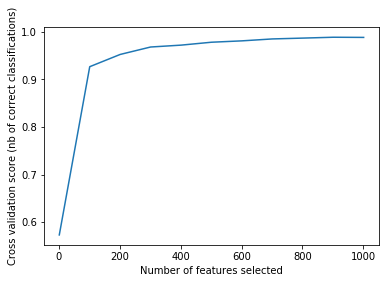

In [59]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1,(len(rfecv.grid_scores_))*100,100), rfecv.grid_scores_)

### Top 600

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=31, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=180, n_jobs=1,
            oob_score=True, random_state=0, verbose=0, warm_start=False)
Optimal number of features : 600
AUROC: 0.8914464336459221 Accuracy:  0.8


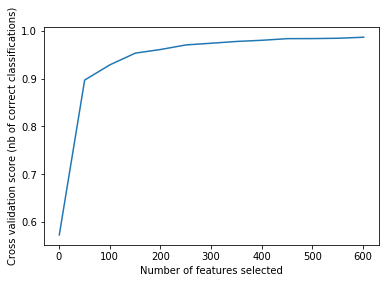

In [61]:
top_600 = TCRs_ind[:600]
# Define a classifier
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
        max_depth=31, max_features='auto', max_leaf_nodes=None,
        min_impurity_decrease=0.0, min_impurity_split=None,
        min_samples_leaf=1, min_samples_split=5,
        min_weight_fraction_leaf=0.0, n_estimators=180, n_jobs=1,
        oob_score=True, random_state=0, verbose=0, warm_start=False)
print(rf)

rfecv = RFECV(rf,cv=StratifiedKFold(10),scoring='roc_auc',step = 50)
rfecv.fit(train_X[:,top_600],train_y)

print("Optimal number of features : %d" % rfecv.n_features_)

print('AUROC:',roc_auc_score(test_y,rfecv.predict_proba(test_X[:,top_600])[:,1]),'Accuracy: ',accuracy_score(test_y,
        rfecv.predict(test_X[:,top_600])))

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1,(len(rfecv.grid_scores_))*50,50), rfecv.grid_scores_)

### Top 350

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=31, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=180, n_jobs=1,
            oob_score=True, random_state=0, verbose=0, warm_start=False)
Optimal number of features : 350
AUROC: 0.9053708439897699 Accuracy:  0.8333333333333334


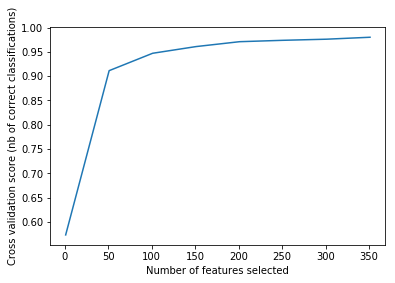

In [63]:
top_350 = TCRs_ind[:350]
# Define a classifier
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
        max_depth=31, max_features='auto', max_leaf_nodes=None,
        min_impurity_decrease=0.0, min_impurity_split=None,
        min_samples_leaf=1, min_samples_split=5,
        min_weight_fraction_leaf=0.0, n_estimators=180, n_jobs=1,
        oob_score=True, random_state=0, verbose=0, warm_start=False)
print(rf)

rfecv = RFECV(rf,cv=StratifiedKFold(10),scoring='roc_auc',step = 50)
rfecv.fit(train_X[:,top_350],train_y)

print("Optimal number of features : %d" % rfecv.n_features_)

print('AUROC:',roc_auc_score(test_y,rfecv.predict_proba(test_X[:,top_350])[:,1]),'Accuracy: ',accuracy_score(test_y,
        rfecv.predict(test_X[:,top_350])))

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1,(len(rfecv.grid_scores_))*50,50), rfecv.grid_scores_)

### Top 200

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=31, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=180, n_jobs=1,
            oob_score=True, random_state=0, verbose=0, warm_start=False)
Optimal number of features : 200
AUROC: 0.9133276499005398 Accuracy:  0.8333333333333334


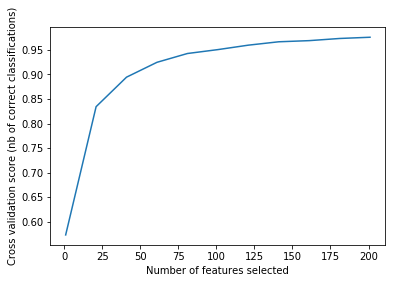

In [67]:
top_200 = TCRs_ind[:200]
# Define a classifier
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
        max_depth=31, max_features='auto', max_leaf_nodes=None,
        min_impurity_decrease=0.0, min_impurity_split=None,
        min_samples_leaf=1, min_samples_split=5,
        min_weight_fraction_leaf=0.0, n_estimators=180, n_jobs=1,
        oob_score=True, random_state=0, verbose=0, warm_start=False)
print(rf)

rfecv = RFECV(rf,cv=StratifiedKFold(10),scoring='roc_auc',step = 20)
rfecv.fit(train_X[:,top_200],train_y)

print("Optimal number of features : %d" % rfecv.n_features_)

print('AUROC:',roc_auc_score(test_y,rfecv.predict_proba(test_X[:,top_200])[:,1]),'Accuracy: ',accuracy_score(test_y,
        rfecv.predict(test_X[:,top_200])))

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1,(len(rfecv.grid_scores_))*20,20), rfecv.grid_scores_)

### Top 165

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=31, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=180, n_jobs=1,
            oob_score=True, random_state=0, verbose=0, warm_start=False)
Optimal number of features : 165
AUROC: 0.9116226200625178 Accuracy:  0.8583333333333333


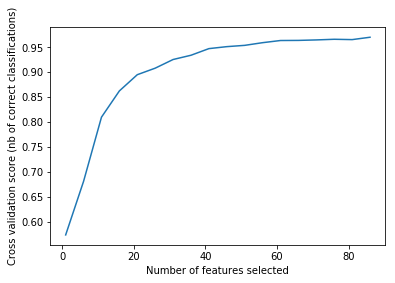

In [65]:
top_165 = TCRs_ind[:165]
# Define a classifier
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
        max_depth=31, max_features='auto', max_leaf_nodes=None,
        min_impurity_decrease=0.0, min_impurity_split=None,
        min_samples_leaf=1, min_samples_split=5,
        min_weight_fraction_leaf=0.0, n_estimators=180, n_jobs=1,
        oob_score=True, random_state=0, verbose=0, warm_start=False)
print(rf)

rfecv = RFECV(rf,cv=StratifiedKFold(10),scoring='roc_auc',step = 10)
rfecv.fit(train_X[:,top_165],train_y)

print("Optimal number of features : %d" % rfecv.n_features_)

print('AUROC:',roc_auc_score(test_y,rfecv.predict_proba(test_X[:,top_165])[:,1]),'Accuracy: ',accuracy_score(test_y,
        rfecv.predict(test_X[:,top_165])))

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1,(len(rfecv.grid_scores_))*5,5), rfecv.grid_scores_)

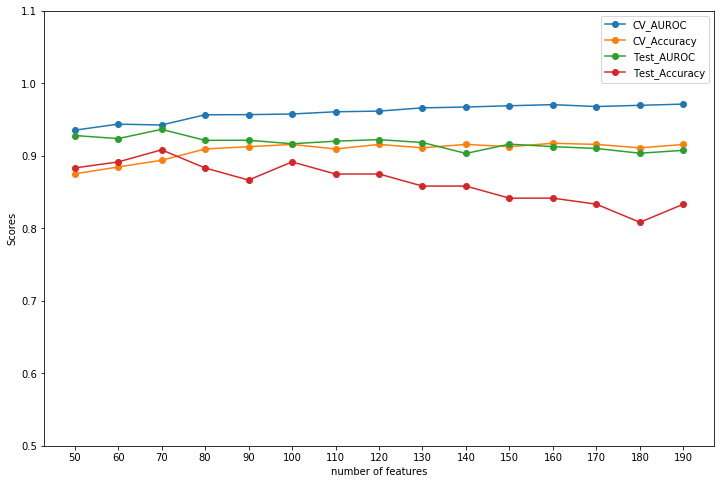

In [78]:
cv_acc = []
cv_auroc = []
test_acc = []
test_auroc = []
for i in range(50,200,10):
    train_X_sub = train_X[:,TCRs_ind[:int(i)]]
    test_X_sub = test_X[:,TCRs_ind[:int(i)]]
    cv_results = cross_validate(rf,train_X_sub,train_y,scoring=('accuracy', 'roc_auc'),cv=StratifiedKFold(10))
    cv_acc.append(np.mean(cv_results['test_accuracy']))
    cv_auroc.append(np.mean(cv_results['test_roc_auc']))

    # fit training set
    clf.fit(X=train_X_sub, y=train_y)

    # predict test_Y
    predict_test = clf.predict(test_X_sub)
    test_acc.append(accuracy_score(test_y, predict_test))

    # AUROC of testing set
    predict_test_prob = clf.predict_proba(test_X_sub)
    pos_prob_test = predict_test_prob[:, 1]
    test_auroc.append(roc_auc_score(test_y, pos_prob_test))
    
    
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
line1 = ax.plot(range(50,200,10),cv_auroc,label='CV_AUROC',marker='o')
line2 = ax.plot(range(50,200,10),cv_acc,label='CV_Accuracy',marker='o')
line3 = ax.plot(range(50,200,10),test_auroc,label='Test_AUROC',marker='o')
line4 = ax.plot(range(50,200,10),test_acc,label='Test_Accuracy',marker='o')

ax.set_ylabel('Scores')
ax.set_xlabel('number of features')
ax.set_xticks(range(50,200,10))
ax.set_yticks(np.arange(0.5,1.1,0.1))
ax.legend(loc='best', bbox_to_anchor=(1,1))

plt.show()

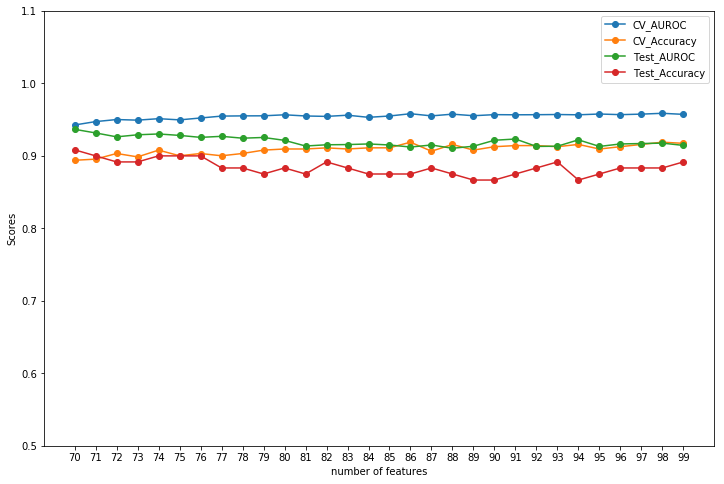

In [81]:
cv_acc = []
cv_auroc = []
test_acc = []
test_auroc = []
for i in range(70,100,1):
    train_X_sub = train_X[:,TCRs_ind[:int(i)]]
    test_X_sub = test_X[:,TCRs_ind[:int(i)]]
    cv_results = cross_validate(rf,train_X_sub,train_y,scoring=('accuracy', 'roc_auc'),cv=StratifiedKFold(10))
    cv_acc.append(np.mean(cv_results['test_accuracy']))
    cv_auroc.append(np.mean(cv_results['test_roc_auc']))

    # fit training set
    clf.fit(X=train_X_sub, y=train_y)

    # predict test_Y
    predict_test = clf.predict(test_X_sub)
    test_acc.append(accuracy_score(test_y, predict_test))

    # AUROC of testing set
    predict_test_prob = clf.predict_proba(test_X_sub)
    pos_prob_test = predict_test_prob[:, 1]
    test_auroc.append(roc_auc_score(test_y, pos_prob_test))
    
    
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
line1 = ax.plot(range(70,100,1),cv_auroc,label='CV_AUROC',marker='o')
line2 = ax.plot(range(70,100,1),cv_acc,label='CV_Accuracy',marker='o')
line3 = ax.plot(range(70,100,1),test_auroc,label='Test_AUROC',marker='o')
line4 = ax.plot(range(70,100,1),test_acc,label='Test_Accuracy',marker='o')

ax.set_ylabel('Scores')
ax.set_xlabel('number of features')
ax.set_xticks(range(70,100,1))
ax.set_yticks(np.arange(0.5,1.1,0.1))
ax.legend(loc='best', bbox_to_anchor=(1,1))

plt.show()

In [93]:
cv_acc = []
cv_auroc = []
test_acc = []
test_auroc = []
for i in range(60,101,1):
    train_X_sub = train_X[:,TCRs_ind[:int(i)]]
    test_X_sub = test_X[:,TCRs_ind[:int(i)]]
    cv_results = cross_validate(rf,train_X_sub,train_y,scoring=('accuracy', 'roc_auc'),cv=StratifiedKFold(10))
    cv_acc = np.mean(cv_results['test_accuracy'])
    cv_auroc = np.mean(cv_results['test_roc_auc'])

    # fit training set
    clf.fit(X=train_X_sub, y=train_y)

    # predict test_Y
    predict_test = clf.predict(test_X_sub)
    acc = accuracy_score(test_y, predict_test)

    # AUROC of testing set
    predict_test_prob = clf.predict_proba(test_X_sub)
    pos_prob_test = predict_test_prob[:, 1]
    auroc = roc_auc_score(test_y, pos_prob_test)
    
    print(i,':')
    print('cv_auroc:',cv_auroc, 'cv_acc:',cv_acc,'auroc:',auroc, 'acc:',acc)

60 :
cv_auroc: 0.9437680819454218 cv_acc: 0.8846588827838827 auroc: 0.9238420005683432 acc: 0.8916666666666667
61 :
cv_auroc: 0.9456896551724139 cv_acc: 0.890860805860806 auroc: 0.9272520602443876 acc: 0.925
62 :
cv_auroc: 0.942757447806709 cv_acc: 0.8815098443223442 auroc: 0.9249786871270247 acc: 0.9
63 :
cv_auroc: 0.9472253499100789 cv_acc: 0.8798992673992674 auroc: 0.9263995453253765 acc: 0.9083333333333333
64 :
cv_auroc: 0.9417174915943389 cv_acc: 0.8783848443223443 auroc: 0.9258312020460358 acc: 0.9
65 :
cv_auroc: 0.9435448432246462 cv_acc: 0.8830723443223443 auroc: 0.9246945154873544 acc: 0.9083333333333333
66 :
cv_auroc: 0.9439545703338806 cv_acc: 0.8877365689865689 auroc: 0.9281045751633986 acc: 0.925
67 :
cv_auroc: 0.9464586754241926 cv_acc: 0.8877846459096459 auroc: 0.9261153736857061 acc: 0.9166666666666666
68 :
cv_auroc: 0.9450390960982095 cv_acc: 0.8923992673992676 auroc: 0.9263995453253765 acc: 0.9166666666666666
69 :
cv_auroc: 0.9442419266557197 cv_acc: 0.897086767399267

In [96]:
train_X_sub = train_X[:,TCRs_ind[:60]]
test_X_sub = test_X[:,TCRs_ind[:60]]
estimator_result(rf,train_X_sub,train_y,test_X_sub,test_y)

********************************************************************************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=31, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=180, n_jobs=1,
            oob_score=True, random_state=0, verbose=0, warm_start=False)

Cross validation:
accuracy score 0.8846588827838827
AUROC 0.9437680819454218
________________________________________________________________________________
Training set:
accuracy score 0.9500780031201248
AUROC 0.9706865366467442
log-loss: 0.2078254189872519
________________________________________________________________________________
Testing set;
accuracy score: 0.8916666666666667
AUROC 0.9238420005683432
log-loss: 0.33740821337011256
classification_report
             precision    recall  f1-score   sup

In [95]:
train_X_sub = train_X[:,TCRs_ind[:61]]
test_X_sub = test_X[:,TCRs_ind[:61]]
estimator_result(rf,train_X_sub,train_y,test_X_sub,test_y)

********************************************************************************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=31, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=180, n_jobs=1,
            oob_score=True, random_state=0, verbose=0, warm_start=False)

Cross validation:
accuracy score 0.890860805860806
AUROC 0.9456896551724139
________________________________________________________________________________
Training set:
accuracy score 0.9547581903276131
AUROC 0.9722052925448255
log-loss: 0.20520231486722498
________________________________________________________________________________
Testing set;
accuracy score: 0.925
AUROC 0.9272520602443876
log-loss: 0.3326559762813858
classification_report
             precision    recall  f1-score   support

        

In [84]:
train_X_sub = train_X[:,TCRs_ind[:70]]
test_X_sub = test_X[:,TCRs_ind[:70]]
estimator_result(rf,train_X_sub,train_y,test_X_sub,test_y)

********************************************************************************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=31, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=180, n_jobs=1,
            oob_score=True, random_state=0, verbose=0, warm_start=False)

Cross validation:
accuracy score 0.893937728937729
AUROC 0.9426190476190476
________________________________________________________________________________
Training set:
accuracy score 0.9563182527301092
AUROC 0.9751690783265179
log-loss: 0.2012110703803166
________________________________________________________________________________
Testing set;
accuracy score: 0.9083333333333333
AUROC 0.9366297243535096
log-loss: 0.3230386044397289
classification_report
             precision    recall  f1-score   suppo

In [94]:
train_X_sub = train_X[:,TCRs_ind[:75]]
test_X_sub = test_X[:,TCRs_ind[:75]]
estimator_result(rf,train_X_sub,train_y,test_X_sub,test_y)

********************************************************************************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=31, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=180, n_jobs=1,
            oob_score=True, random_state=0, verbose=0, warm_start=False)

Cross validation:
accuracy score 0.9001396520146521
AUROC 0.9496803893971382
________________________________________________________________________________
Training set:
accuracy score 0.9563182527301092
AUROC 0.9777642340358602
log-loss: 0.19306311586515598
________________________________________________________________________________
Testing set;
accuracy score: 0.9
AUROC 0.9282466609832337
log-loss: 0.3369141663254706
classification_report
             precision    recall  f1-score   support

         

**Top 61,70,75 is optional**